In [14]:
# Імпорт бібліотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Налаштування відображення
plt.style.use('seaborn-v0_8')
seaborn.set(font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
#завантаження даних
data = pd.read_csv("C:/Users/User/Downloads/BMW sales data (2010-2024) (1).csv")

print("Dataset info")
print(f"Розмір датасету: {data.shape}")
print("\nПерші 5 рядків:")
print(data.head())

Dataset info
Розмір датасету: (50000, 11)

Перші 5 рядків:
      Model  Year         Region  Color Fuel_Type Transmission  Engine_Size_L  \
0  5 Series  2016           Asia    Red    Petrol       Manual            3.5   
1        i8  2013  North America    Red    Hybrid    Automatic            1.6   
2  5 Series  2022  North America   Blue    Petrol    Automatic            4.5   
3        X3  2024    Middle East   Blue    Petrol    Automatic            1.7   
4  7 Series  2020  South America  Black    Diesel       Manual            2.1   

   Mileage_KM  Price_USD  Sales_Volume Sales_Classification  
0      151748      98740          8300                 High  
1      121671      79219          3428                  Low  
2       10991     113265          6994                  Low  
3       27255      60971          4047                  Low  
4      122131      49898          3080                  Low  


In [4]:
#LabelEncoder
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

data['Model'] = label_encoder.fit_transform(data['Model'])
data['Region'] = label_encoder.fit_transform(data['Region'])
data['Color'] = label_encoder.fit_transform(data['Color'])
data['Fuel_Type'] = label_encoder.fit_transform(data['Fuel_Type'])
data['Transmission'] = label_encoder.fit_transform(data['Transmission'])

In [5]:
#визначаємо дані
data['Sales_Classification'] = data['Sales_Classification'].map({'High': 1, 'Low': 0})
data_small = data.sample(5000, random_state=42)

X = data_small.drop('Sales_Classification', axis=1)
y = data_small['Sales_Classification']

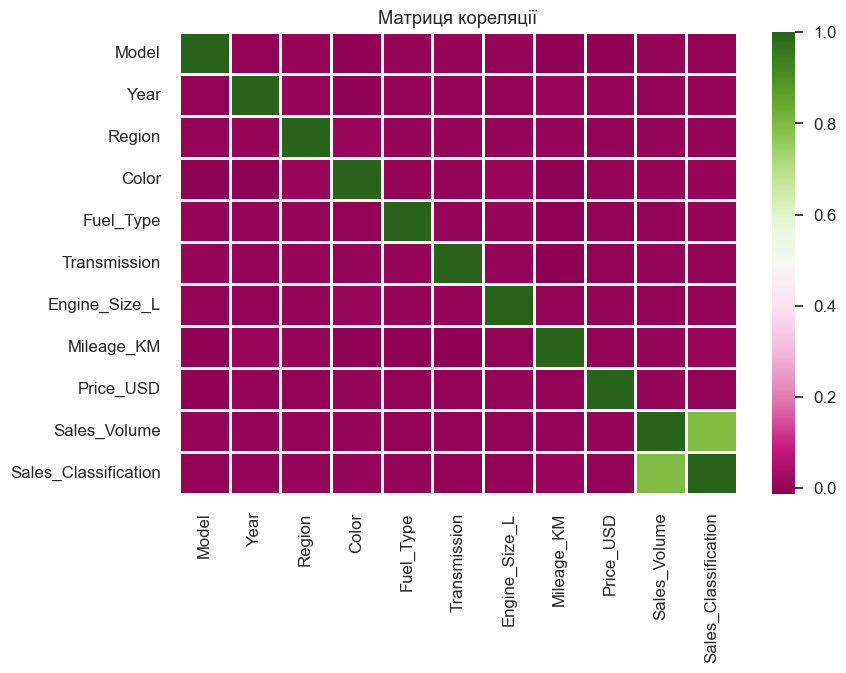

In [6]:
#матриця кореляції
plt.figure(figsize=(9, 6))
seaborn.heatmap(data.corr(), cmap='PiYG', linewidths=1)
plt.title('Матриця кореляції')
plt.show()

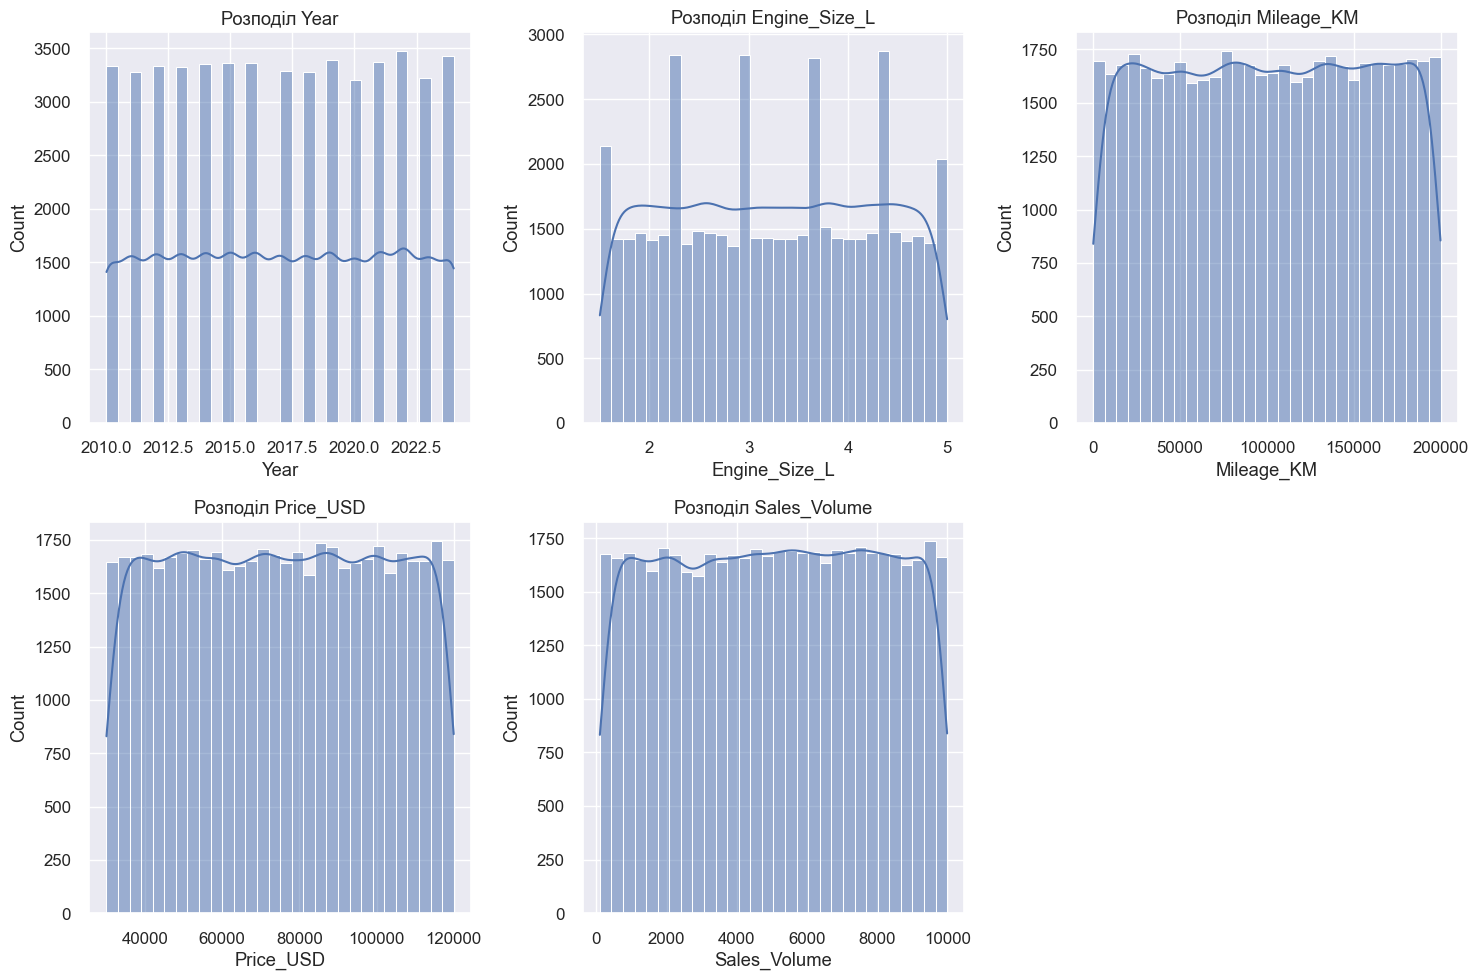

In [7]:
#гістограми
num_features = ['Year', 'Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume']
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_features, 1):
    plt.subplot(2, 3, i)
    seaborn.histplot(data[col], kde=True, bins=30)
    plt.title(f'Розподіл {col}')
plt.tight_layout()
plt.show()

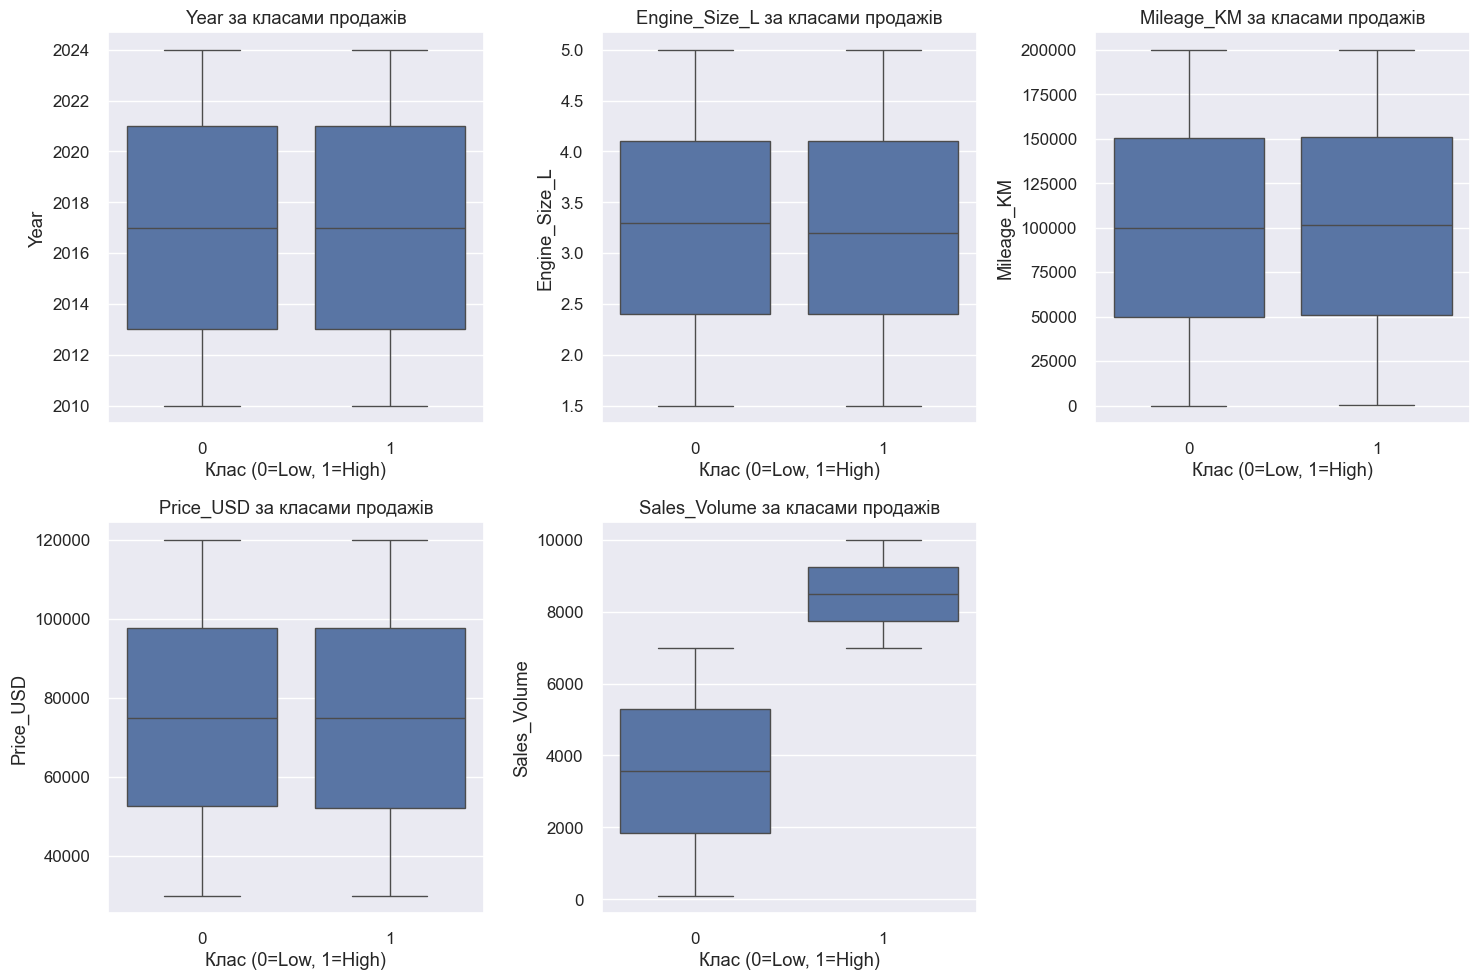

In [8]:
#boxplot
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_features, 1):
    plt.subplot(2, 3, i)
    seaborn.boxplot(x='Sales_Classification', y=col, data=data)
    plt.title(f'{col} за класами продажів')
    plt.xlabel('Клас (0=Low, 1=High)')
plt.tight_layout()
plt.show()

In [9]:
#розбиття на тренувальну і тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
#нормалізація даних
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
#навчання
results = {}

# kNN
k_range = range(1, 30)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    score = knn.score(X_test_scaled, y_test)
    k_scores.append(score)

best_k = k_range[np.argmax(k_scores)]


knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)

#прогноз
y_pred_knn = knn_best.predict(X_test_scaled)
results['kNN'] = accuracy_score(y_test, y_pred_knn)

In [12]:
#decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)
results['Decision Tree'] = accuracy_score(y_test, y_pred_dt)

In [15]:
#svm
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly']
}

svm_grid = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

svm_best = svm_grid.best_estimator_
y_pred_svm = svm_best.predict(X_test_scaled)
results['SVM'] = accuracy_score(y_test, y_pred_svm)

In [16]:
#random forest
rf = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=15)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
results['Random Forest'] = accuracy_score(y_test, y_pred_rf)

In [17]:
#ada boost
ada = AdaBoostClassifier(n_estimators=200, random_state=42, learning_rate=0.8)
ada.fit(X_train_scaled, y_train)
y_pred_ada = ada.predict(X_test_scaled)
results['AdaBoost'] = accuracy_score(y_test, y_pred_ada)

In [21]:
#results
print("\n" + "="*60)
print("ТОЧНІСТЬ МОДЕЛЕЙ".center(60))
print("="*60)
for name, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:20} → {acc:.4f} {'★' if acc == max(results.values()) else ''}")

best_model_name = max(results, key=results.get)
print(f"\nНАЙКРАЩА МОДЕЛЬ: {best_model_name} з точністю {results[best_model_name]:.4f}")


                      ТОЧНІСТЬ МОДЕЛЕЙ                      
Decision Tree        → 1.0000 ★
Random Forest        → 1.0000 ★
AdaBoost             → 1.0000 ★
SVM                  → 0.9900 
kNN                  → 0.9353 

НАЙКРАЩА МОДЕЛЬ: Decision Tree з точністю 1.0000


Metrics and Confusion Matrix
              precision    recall  f1-score   support

   Low Sales       1.00      1.00      1.00      1036
  High Sales       1.00      1.00      1.00       464

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500

Матриця помилок:


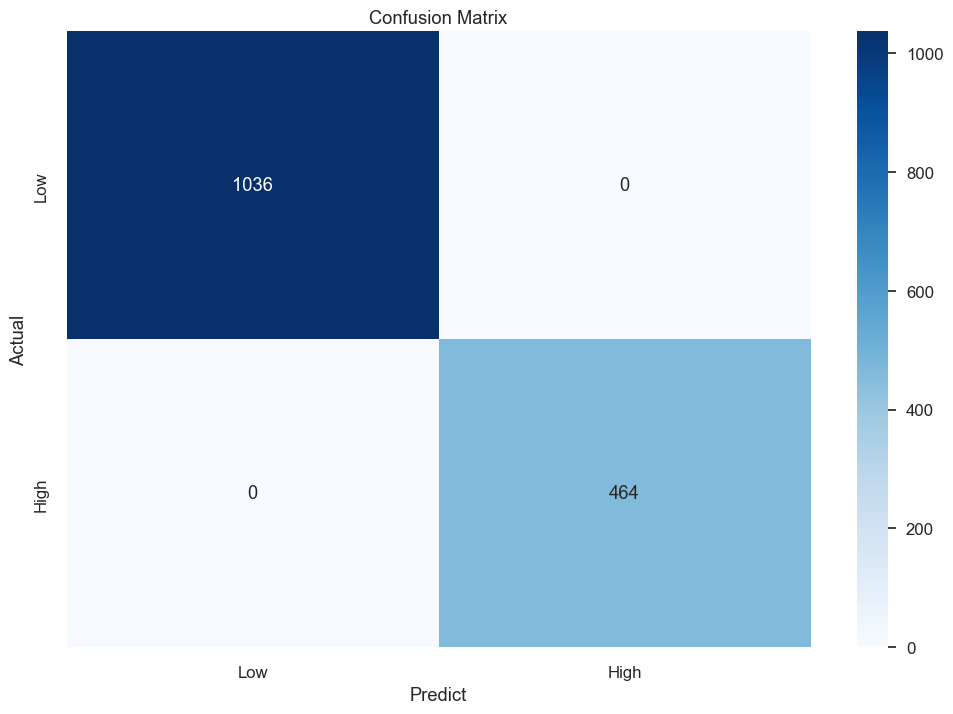

In [22]:
#метрики та матриця помилок
print(f"Metrics and Confusion Matrix")
print(classification_report(y_test, best_predictions[best_model_name], 
                          target_names=['Low Sales', 'High Sales']))

print("Матриця помилок:")
cm = confusion_matrix(y_test, best_predictions[best_model_name])
seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix')
plt.show()